## Load Data

In [38]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# path to data file
df_1 = pd.read_csv("/Users/murphy.chen/Desktop/data1030final_project/data/raw/Ad_table.csv", low_memory=False)
df_2 = pd.read_csv("/Users/murphy.chen/Desktop/data1030final_project/data/raw/Ad_table (extra).csv", low_memory=False)

df = pd.concat([df_1, df_2], ignore_index=True)

# check the combined data
print(df.shape)
print(list(df.columns))

(536510, 25)
['Maker', 'Genmodel', 'Genmodel_ID', 'Adv_ID', 'Adv_year', 'Adv_month', 'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engin_size', 'Gearbox', 'Fuel_type', 'Price', 'Seat_num', 'Door_num', ' Genmodel_ID', 'Engine_power', 'Annual_Tax', 'Wheelbase', 'Height', 'Width', 'Length', 'Average_mpg', 'Top_speed']


## Data Cleaning

In [29]:
# start with keeping the necessary columns
columns_to_keep = ["Maker", 
                   "Genmodel", 
                   "Color", 
                   "Reg_year", 
                   "Bodytype", 
                   "Runned_Miles", 
                   "Engin_size", 
                   "Gearbox", 
                   "Fuel_type", 
                   "Price", 
                   "Seat_num",  
                   "Door_num"]

df = df[columns_to_keep].copy()

# check the new data columns
print(df.shape)
print(list(df.columns))

(536510, 12)
['Maker', 'Genmodel', 'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engin_size', 'Gearbox', 'Fuel_type', 'Price', 'Seat_num', 'Door_num']


In [30]:
# clean and standardize the names
df.columns = (
    df.columns
    .str.strip()            
    .str.lower()             
    .str.replace(" ", "_")     
    .str.replace("-", "_") 
)

# check the cleaned column names
print(df.columns.tolist())

# rename some columns for better clarity
df = df.rename(columns={
    "runned_miles": "mileage",
    "engin_size": "engine_size",
    "genmodel": "model",
    "maker": "brand"
})

# check the renamed column names
print(df.columns.tolist())

['maker', 'genmodel', 'color', 'reg_year', 'bodytype', 'runned_miles', 'engin_size', 'gearbox', 'fuel_type', 'price', 'seat_num', 'door_num']
['brand', 'model', 'color', 'reg_year', 'bodytype', 'mileage', 'engine_size', 'gearbox', 'fuel_type', 'price', 'seat_num', 'door_num']


In [31]:
# check data types
print(df.dtypes)

brand           object
model           object
color           object
reg_year       float64
bodytype        object
mileage         object
engine_size     object
gearbox         object
fuel_type       object
price           object
seat_num       float64
door_num       float64
dtype: object


In [32]:
# clean numeric columns
def clean_numeric(series):
    return (
        series.astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("km", "", case=False, regex=False)
        .str.replace("l", "", case=False, regex=False)
         .str.extract(r"(-?\d+\.?\d*)")[0]
        .astype(float)
    )

# apply the cleaning function to numeric columns
df["price"] = clean_numeric(df["price"])
df["mileage"] = clean_numeric(df["mileage"])
df["engine_size"] = clean_numeric(df["engine_size"])

for col in ["reg_year", "seat_num", "door_num"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df[["price", "mileage", "engine_size", "reg_year", "seat_num", "door_num"]].head())


     price  mileage  engine_size  reg_year  seat_num  door_num
0  21500.0  60000.0          6.8    2000.0       5.0       4.0
1  28750.0  44000.0          6.8    2002.0       5.0       4.0
2  29999.0  55000.0          6.8    2002.0       5.0       4.0
3  34948.0  14000.0          6.8    2003.0       5.0       4.0
4  26555.0  61652.0          6.8    2003.0       5.0       4.0


In [84]:
def simplify_fuel_type(x):
    if pd.isna(x):
        return "Other"
    x = x.lower().strip()
    if "petrol" in x and "electric" in x:
        return "Hybrid"
    elif "diesel" in x and "electric" in x:
        return "Hybrid"
    elif "plug" in x:
        return "Hybrid"
    elif "hybrid" in x:
        return "Hybrid"
    elif "electric" in x:
        return "Electric"
    elif "petrol" in x:
        return "Petrol"
    elif "diesel" in x:
        return "Diesel"
    else:
        return "Other"

df["fuel_type_clean"] = df["fuel_type"].apply(simplify_fuel_type)

In [36]:
# Count missing values per column
missing_count = df.isna().sum()
missing_fraction = missing_count / len(df)

missing_table = (
    pd.DataFrame({
        "missing_count": missing_count,
        "missing_fraction":(missing_fraction*100).round(2)
    })
    .query("missing_count > 0")
    .sort_values(by="missing_fraction", ascending=False)
)

print(missing_table)

             missing_count  missing_fraction
color                43750              8.15
seat_num             12948              2.41
door_num              9106              1.70
engine_size           4128              0.77
price                 2290              0.43
mileage               2110              0.39
bodytype              1908              0.36
fuel_type              818              0.15
gearbox                334              0.06
reg_year                14              0.00


In [53]:
# check data types
print(df.dtypes)

brand              object
model              object
color              object
reg_year          float64
bodytype           object
mileage           float64
engine_size       float64
gearbox            object
fuel_type          object
price             float64
seat_num          float64
door_num          float64
price_range      category
mileage_range    category
dtype: object


## EDA

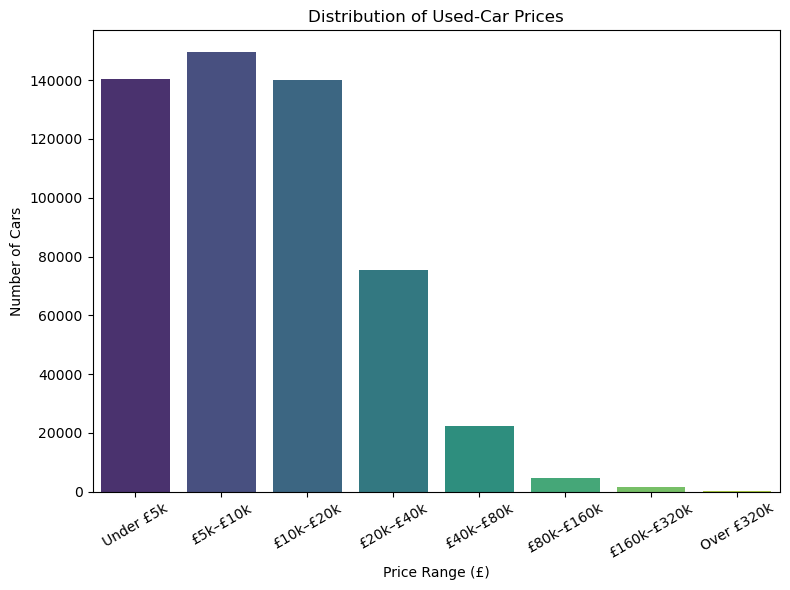

In [ ]:
# Price Distribution Visualization
bins = [0, 5000, 10000, 20000, 40000, 80000, 160000, 320000, df["price"].max()]
labels = [
    "Under £5k", 
    "£5k–£10k", 
    "£10k–£20k", 
    "£20k–£40k", 
    "£40k–£80k", 
    "£80k–£160k", 
    "£160k–£320k", 
    "Over £320k"
]

df["price_range"] = pd.cut(df["price"], bins=bins, labels=labels, include_lowest=True)


plt.figure(figsize=(8,6))
order = df["price_range"].value_counts().sort_index(ascending=True)

sns.barplot(
    x=order.index,
    y=order.values,
    hue=order.index,          
    legend=False,            
    palette="viridis"
)

plt.xlabel("Price Range (£)")
plt.ylabel("Number of Cars")
plt.title("Distribution of Used-Car Prices")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


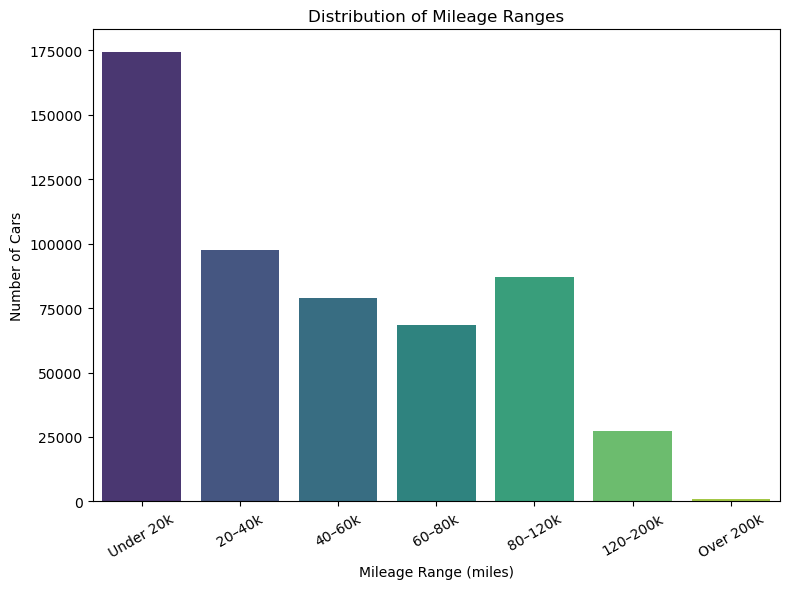

In [ ]:
# Mileage Distribution Visualization
mile_bins = [0, 20000, 40000, 60000, 80000, 120000, 200000, df["mileage"].max()]

mile_labels = [
    "Under 20k",
    "20–40k",
    "40–60k",
    "60–80k",
    "80–120k",
    "120–200k",
    "Over 200k"
]

df["mileage_range"] = pd.cut(
    df["mileage"], bins=mile_bins, labels=mile_labels, include_lowest=True
)

order = df["mileage_range"].value_counts().reindex(mile_labels)

plt.figure(figsize=(8,6))
sns.barplot(
    x=order.index,
    y=order.values,
    hue=order.index,
    legend=False,
    palette="viridis"
)
plt.xlabel("Mileage Range (miles)")
plt.ylabel("Number of Cars")
plt.title("Distribution of Mileage Ranges")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

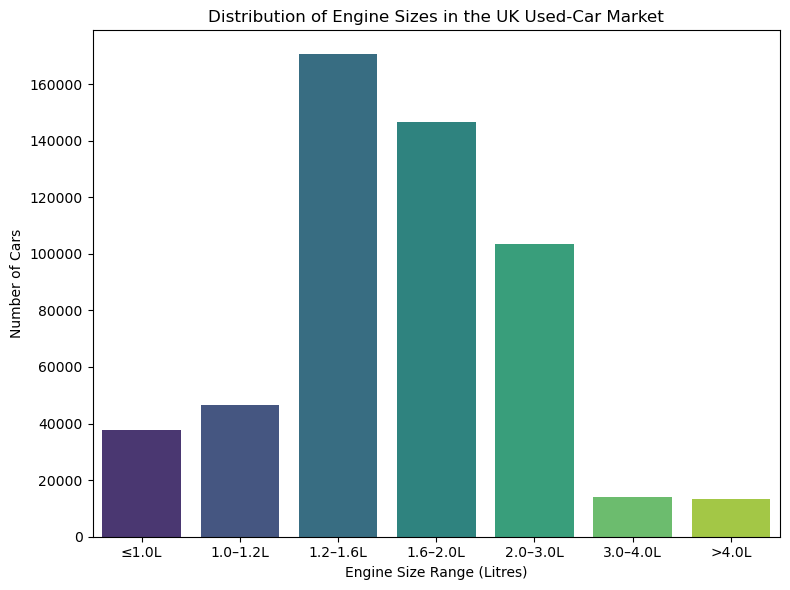

In [58]:
# Engine Size Distribution Visualization
engine_bins = [0, 1.0, 1.2, 1.6, 2.0, 3.0, 4.0, df["engine_size"].max()]
engine_labels = [
    "≤1.0L",
    "1.0–1.2L",
    "1.2–1.6L",
    "1.6–2.0L",
    "2.0–3.0L",
    "3.0–4.0L",
    ">4.0L"
]

# Categorize into bins
df["engine_range"] = pd.cut(df["engine_size"], bins=engine_bins, labels=engine_labels, include_lowest=True)

# Count per range
order = df["engine_range"].value_counts().reindex(engine_labels)

plt.figure(figsize=(8,6))
sns.barplot(
    x=order.index,
    y=order.values,
    hue=order.index,
    legend=False,
    palette="viridis"
)
plt.xlabel("Engine Size Range (Litres)")
plt.ylabel("Number of Cars")
plt.title("Distribution of Engine Sizes in the UK Used-Car Market")
plt.tight_layout()
plt.show()

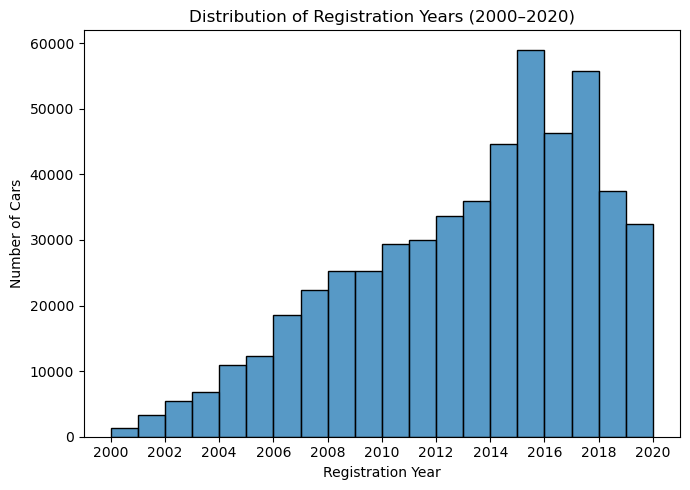

In [75]:
# Registration Year Distribution Visualization
df_valid_years = df[(df["reg_year"] >= 2000) & (df["reg_year"] <= 2020)]

plt.figure(figsize=(7,5))
sns.histplot(
    df_valid_years["reg_year"],
    bins=range(2000, 2021),
)

plt.xticks(range(2000, 2021, 2)) 
plt.xlabel("Registration Year")
plt.ylabel("Number of Cars")
plt.title("Distribution of Registration Years (2000–2020)")
plt.tight_layout()
plt.show()

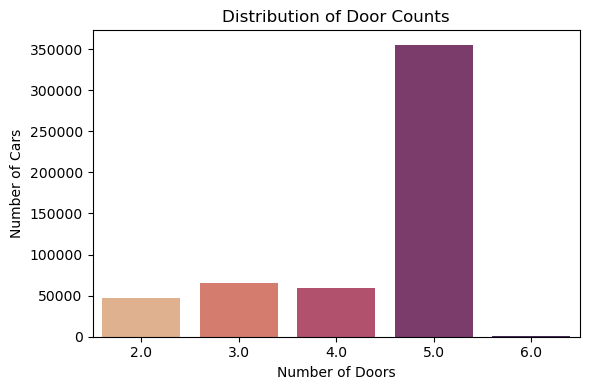

In [81]:
df_valid_doors = df[df["door_num"].between(1, 6)]

plt.figure(figsize=(6,4))
sns.countplot(
    x="door_num",
    hue="door_num",
    data=df_valid_doors,
    legend=False,
    palette="flare"
)
plt.xlabel("Number of Doors")
plt.ylabel("Number of Cars")
plt.title("Distribution of Door Counts")
plt.tight_layout()
plt.show()

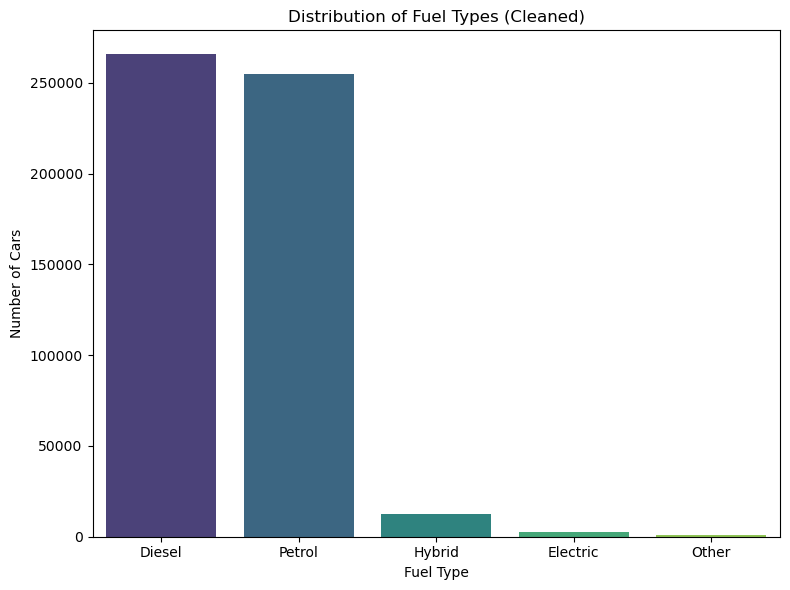

In [88]:
fuel_counts = df["fuel_type_clean"].value_counts()

plt.figure(figsize=(8,6))
sns.barplot(
    x=fuel_counts.index,
    y=fuel_counts.values,
    hue=fuel_counts.index,
    legend=False,
    palette="viridis"
)
plt.xlabel("Fuel Type")
plt.ylabel("Number of Cars")
plt.title("Distribution of Fuel Types (Cleaned)")
plt.tight_layout()
plt.show()

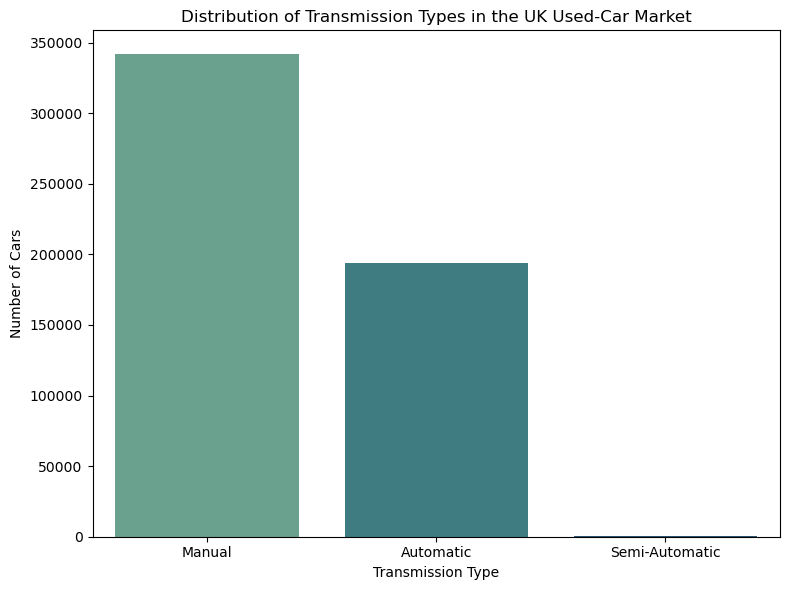

In [91]:
gear_counts = df["gearbox"].value_counts(dropna=True)

plt.figure(figsize=(8,6))
sns.barplot(
    x=gear_counts.index,
    y=gear_counts.values,
    hue=gear_counts.index,
    legend=False,
    palette="crest"
)
plt.xlabel("Transmission Type")
plt.ylabel("Number of Cars")
plt.title("Distribution of Transmission Types in the UK Used-Car Market")
plt.tight_layout()
plt.show()